In [94]:
import numpy as np
import pandas as pd
# %pip install matplotlib
import matplotlib.pyplot as plt
# %pip install seaborn
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [95]:
dataM = pd.read_csv('./data.csv')
dataM[dataM.columns] = dataM[dataM.columns].astype('Int64')

In [96]:
dataM = dataM.drop('Final_EDSS', axis=1)
dataM = dataM.drop('Unnamed: 0', axis=1)

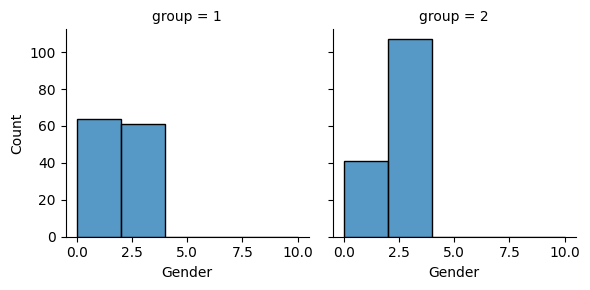

In [97]:
g = sns.FacetGrid(dataM, col="group", margin_titles=True)

g.map_dataframe(sns.histplot, x="Gender", binwidth=2, binrange=(0, 10))

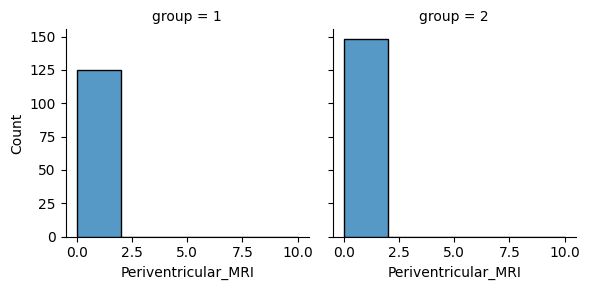

In [98]:
g = sns.FacetGrid(dataM, col="group", margin_titles=True)

g.map_dataframe(sns.histplot, x="Periventricular_MRI", binwidth=2, binrange=(0, 10))

In [99]:
dataM.groupby('group')["Periventricular_MRI"].mean()

group
1         0.8
2    0.256757
Name: Periventricular_MRI, dtype: Float64

In [100]:
dataM.groupby('group')["Infratentorial_MRI"].mean()

group
1       0.504
2    0.114865
Name: Infratentorial_MRI, dtype: Float64

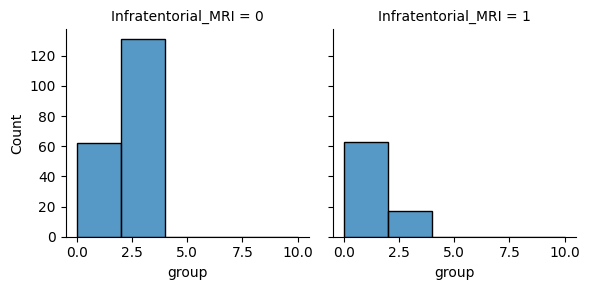

In [101]:
g = sns.FacetGrid(dataM, col="Infratentorial_MRI", margin_titles=True)

g.map_dataframe(sns.histplot, x="group", binwidth=2, binrange=(0, 10))

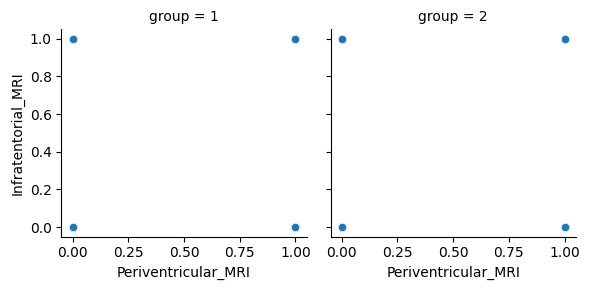

In [102]:
g = sns.FacetGrid(dataM, col="group", margin_titles=True)

g.map_dataframe(sns.scatterplot, x="Periventricular_MRI", y="Infratentorial_MRI")

### Modelo 1 MODIFICANDO indices en initial-edss - random forest

In [103]:
dataM['group'] = dataM['group'].replace(2, 0)

In [104]:
# valores faltantes en initial_edss
indices_faltantes = dataM[dataM['Initial_EDSS'].isnull()].index
num_missing = len(indices_faltantes)
print(num_missing) #cuantos nan hay

148


In [105]:
# Calcular la cantidad de valores a asignar a cada categoría
quarter = num_missing // 4
remainder = num_missing % 4

# Crear una nueva columna para indicar si se imputó un valor
dataM['imputado?'] = 0
dataM.loc[indices_faltantes, 'imputado?'] = 1

# dataM

In [106]:
dataM['Initial_EDSS'].value_counts()

Initial_EDSS
1    87
2    31
3     7
Name: count, dtype: Int64

### exactitud de los modelos dependiendo de cuanto porciento se le quita a initial (general)

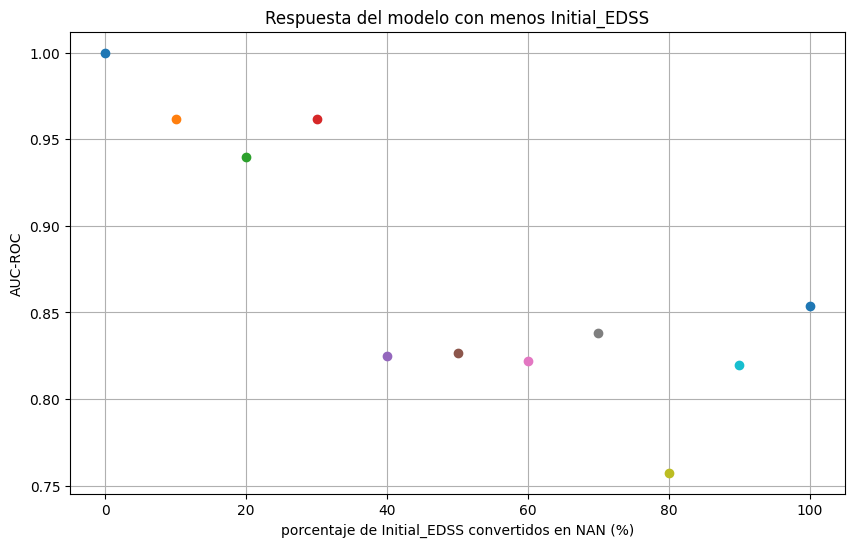

In [107]:

def random_y_conversor(dataM, porcentaje):
  # randomizar la conversion
  dataM = dataM.sample(frac=1)

  tiene_initial = dataM[dataM['Initial_EDSS'].notnull()].index
  num_de_convertidos = int(len(tiene_initial) * porcentaje / 100)

  #  seleccion de idniindices de manera random
  indices_a_convertir = np.random.choice(tiene_initial, size=num_de_convertidos, replace=False)
  dataM.loc[indices_a_convertir, 'Initial_EDSS'] = np.nan

  # Drop shuffled and converted data
  X = dataM.drop('group', axis=1)
  y = dataM['group']
  X = X.drop('imputado?', axis=1)
  return X, y


auc_scores = []
porcentajes = range(0, 101, 10)  # Percentages from 0% to 100% with 10% intervals



for porcentaje in porcentajes:
  X, y = random_y_conversor(dataM.copy(), porcentaje)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


  # Train 
  rf = RandomForestClassifier(random_state=42)
  rf.fit(X_train, y_train)

  # Evaluate
  y_pred = rf.predict(X_val)
  roc_auc = roc_auc_score(y_val, y_pred)
  auc_scores.append(roc_auc)


plt.figure(figsize=(10, 6))
for i, porcentaje in enumerate(porcentajes):
  plt.plot(porcentajes[i], auc_scores[i],'-o')

plt.xlabel("porcentaje de Initial_EDSS convertidos en NAN (%)")
plt.ylabel("AUC-ROC")
plt.title("Respuesta del modelo con menos Initial_EDSS")
plt.grid(True)
plt.show()


### exactitud de los modelos dependiendo de cuanto porciento se le quita a initial (1)

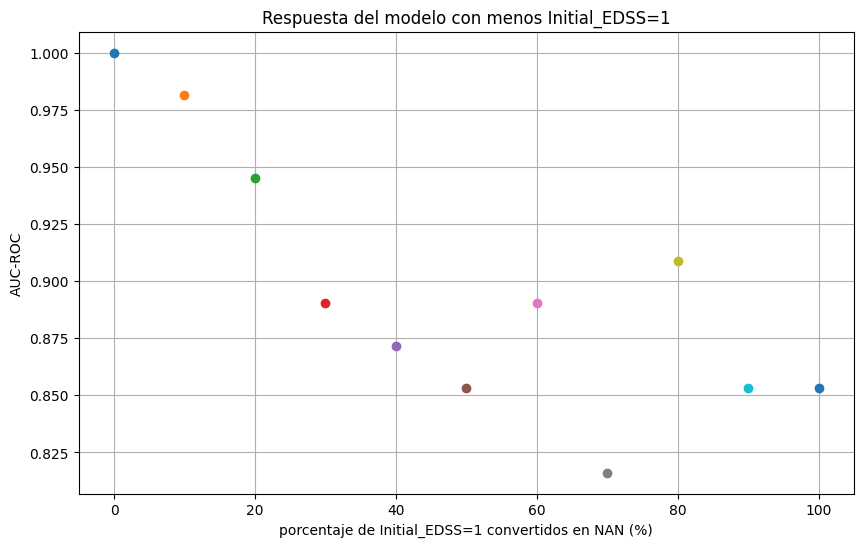

In [110]:
def conversor_1(dataM, porcentajee):
    
    indices_a_convertirr = dataM[dataM['Initial_EDSS'] == 1].index
    num_de_convertidoss = int(len(indices_a_convertirr) * porcentajee / 100)

    # Selecciona aleatoriamente los índices a convertir
    indices_a_convertirr = np.random.choice(indices_a_convertirr, size=num_de_convertidoss, replace=False)

    # Convierte los valores seleccionados a NaN
    dataM.loc[indices_a_convertirr, 'Initial_EDSS'] = np.nan

   # Drop shuffled and converted data
    X = dataM.drop('group', axis=1)
    y = dataM['group']
    X = X.drop('imputado?', axis=1)
    return X, y


auc_scoress = []
porcentajess = range(0, 101, 10)  # Percentages from 0% to 50% with 10% intervals



for porcentajee in porcentajess:
  X, y = conversor_1 (dataM.copy(), porcentajee)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


  # Train 
  rf = RandomForestClassifier(random_state=42)
  rf.fit(X_train, y_train)

  # Evaluate
  y_predd = rf.predict(X_val)
  roc_aucc = roc_auc_score(y_val, y_predd)
  auc_scoress.append(roc_aucc)


plt.figure(figsize=(10, 6))
for i, porcentajee in enumerate(porcentajess):
  plt.plot(porcentajess[i], auc_scoress[i],'-o')

plt.xlabel("porcentaje de Initial_EDSS=1 convertidos en NAN (%)")
plt.ylabel("AUC-ROC")
plt.title("Respuesta del modelo con menos Initial_EDSS=1")
plt.grid(True)
plt.show()

### exactitud de los modelos dependiendo de cuanto porciento se le quita a initial (2)

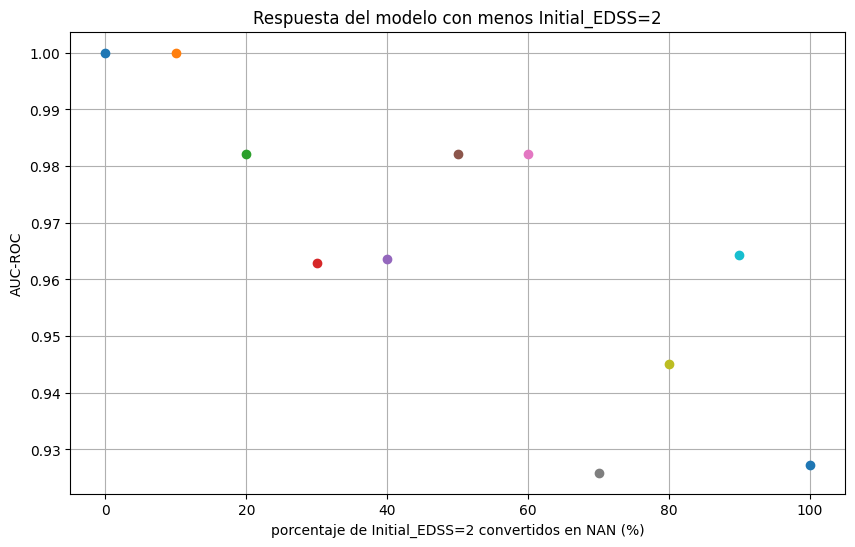

In [113]:
def conversor_2(dataM, porcentajeee):
    
    indices_a_convertirrr = dataM[dataM['Initial_EDSS'] == 2].index
    num_de_convertidosss = int(len(indices_a_convertirrr) * porcentajeee / 100)

    # Selecciona aleatoriamente los índices a convertir
    indices_a_convertirrr = np.random.choice(indices_a_convertirrr, size=num_de_convertidosss, replace=False)

    # Convierte los valores seleccionados a NaN
    dataM.loc[indices_a_convertirrr, 'Initial_EDSS'] = np.nan

   # Drop shuffled and converted data
    X = dataM.drop('group', axis=1)
    y = dataM['group']
    X = X.drop('imputado?', axis=1)
    return X, y

auc_scoresss = []
porcentajesss = range(0, 101, 10)

for porcentajeee in porcentajesss:
  X, y = conversor_2 (dataM.copy(), porcentajeee)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


  # Train 
  rf = RandomForestClassifier(random_state=42)
  rf.fit(X_train, y_train)

  # Evaluate
  y_preddd = rf.predict(X_val)
  roc_auccc = roc_auc_score(y_val, y_preddd)
  auc_scoresss.append(roc_auccc)


plt.figure(figsize=(10, 6))
for i, porcentajeee in enumerate(porcentajesss):
  plt.plot(porcentajesss[i], auc_scoresss[i],'-o')

plt.xlabel("porcentaje de Initial_EDSS=2 convertidos en NAN (%)")
plt.ylabel("AUC-ROC")
plt.title("Respuesta del modelo con menos Initial_EDSS=2")
plt.grid(True)
plt.show()

# FIN DEL ARCHIVO. 
## CONCLUSION: La columna initial molesta mucho debido a su desbalance, ya sea con 1,2,3) o con los NaN.